# AI607 term project

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks/BBE/AI607/Project/

/content/drive/MyDrive/Colab Notebooks/BBE/AI607/Project


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.datasets import OGB_MAG

import matplotlib.pyplot as plt
from itertools import combinations

import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero, GCNConv, GATv2Conv

## Score prediction

### Import Data

In [ ]:
o_train_df = pd.read_csv('one2one_training.csv')
s_train_df = pd.read_csv('survival_training.csv')
s_val_q_df = pd.read_csv("survival_valid_query.csv")
s_val_a_df = pd.read_csv("survival_valid_answer.csv")
s_val_df = pd.concat([s_val_q_df,s_val_a_df], axis=1)
o_val_q_df = pd.read_csv("one2one_valid_query.csv")
o_val_a_df = pd.read_csv("one2one_valid_answer.csv")
o_val_df = pd.concat([o_val_q_df,o_val_a_df], axis=1)
o_val_df = o_val_df.loc[:, ~o_val_df.T.duplicated()]
test_df = pd.read_csv("survival_test_query.csv")

In [ ]:
len(s_train_df)

48008

#### PageRank calculation

In [ ]:
from networkx import pagerank, degree_centrality
from tqdm import tqdm
from collections import defaultdict
import networkx as nx

G = nx.DiGraph()
score_dict = defaultdict()
for g in tqdm(range(len(s_train_df))):
  game = s_train_df.iloc[g, :].dropna()
  date = game['date']
  data = []

  for n in range(int((len(game)-2)/2)):
    id_score = game.iloc[2+n*2:4+n*2].values.tolist()
    id = id_score[0]
    score = id_score[1]
    data.append(id_score)

  sorted_data = sorted(data, key=lambda x: x[1])

  for i in range(int(len(sorted_data)-1)):
    for j in range(i+1,int(len(sorted_data))):
      small_node_id = sorted_data[i][0]
      large_node_id = sorted_data[j][0]
      small_node_score = sorted_data[i][1]
      large_node_score = sorted_data[j][1]
      if small_node_score == 0 :
        if large_node_score == 0 :
          if G.has_edge(i, j) :
            G[i][j]['weight'] += 1
          else :
            G.add_edge(small_node_id, large_node_id, weight = 1)
        else :
          if G.has_edge(i, j) :
            G[i][j]['weight'] += large_node_score
          else:
            G.add_edge(small_node_id,large_node_id, weight = large_node_score)
      else :
        if G.has_edge(i,j) :
          G[i][j]['weight'] += (large_node_score-small_node_score) + 1
        else:
          G.add_edge(small_node_id, large_node_id, weight = (large_node_score-small_node_score) + 1)

page_rank = pagerank(G, max_iter = 100, weight = 'weight')

page_rank_std = np.std(list(page_rank.values()))
page_rank_mean = np.mean(list(page_rank.values()))

scaled_page_rank = {}
for player, pg_score in page_rank.items():
    scaled_pg = (pg_score - page_rank_mean)/page_rank_std
    scaled_page_rank[player] = scaled_pg

100%|██████████| 48008/48008 [00:45<00:00, 1066.02it/s]


Calculate average score in survival game

In [ ]:
# Initialize a dictionary to store the total scores and the number of games played for each player
player_scores = {}
player_games_played = {}
players = []

# Iterate through the rows of the DataFrame
for index, row in s_train_df.iterrows():
  p_number = int((len(row.dropna())-2)/2)
  for i in range(p_number):
    player = row[f'player {i}']
    score = row[f'score {i}']
    player = int(player)
    players.append(player)
    player_scores[player] = player_scores.get(player, 0) + score
    player_games_played[player] = player_games_played.get(player, 0) + 1

for index, row in s_val_df.iterrows():
  p_number = int((len(row.dropna())-3)/2)
  for i in range(p_number):
    player = row[f'player {i}']
    score = row[f'score {i}']
    player = int(player)
    players.append(player)
    player_scores[player] = player_scores.get(player, 0) + score
    player_games_played[player] = player_games_played.get(player, 0) + 1

for index, row in test_df.iterrows():
  p_number = int(len(row.dropna())-2)
  for i in range(p_number):
    player = row[f'player {i}']
    player = int(player)
    players.append(player)

#list of players
player_idx = sorted(list(set(players)))

# Calculate the average score for each player
player_avg_scores = {}
for player, total_score in player_scores.items():
    games_played = player_games_played[player]
    avg_score = total_score / games_played
    player_avg_scores[player] = avg_score

average_of_average_scores = sum(player_avg_scores.values()) / len(player_avg_scores)

Calculate average winning probability in  one2one game

In [ ]:
# Initialize a dictionary to store the total counts and the number of games played for each player
player_counts = {}
one_player_games_played = {}

# Iterate through the rows of the DataFrame
def counts(df,player_counts,one_player_games_played):
  for index, row in df.iterrows():
      winner = row['winner']
      player1 = int(row['player 1'])
      player2 = int(row['player 2'])

      if winner == 'p1':
        player_counts[player1] = player_counts.get(player1, 0) + 1
        one_player_games_played[player1] = one_player_games_played.get(player1, 0) + 1
        one_player_games_played[player2] = one_player_games_played.get(player2, 0) + 1
      elif winner == 'p2':
        player_counts[player2] = player_counts.get(player2, 0) + 1
        one_player_games_played[player2] = one_player_games_played.get(player2, 0) + 1
        one_player_games_played[player1] = one_player_games_played.get(player1, 0) + 1
      elif winner == 'DRAW':
        player_counts[player1] = player_counts.get(player1, 0) + 0.5
        one_player_games_played[player1] = one_player_games_played.get(player1, 0) + 1
        player_counts[player2] = player_counts.get(player2, 0) + 0.5
        one_player_games_played[player2] = one_player_games_played.get(player2, 0) + 1
  return player_counts,one_player_games_played

player_counts,one_player_games_played = counts(o_train_df,player_counts,one_player_games_played)
player_counts,one_player_games_played = counts(o_val_df,player_counts,one_player_games_played)

# Calculate the average score for each player
player_avg_counts = {}
for player, total_score in player_counts.items():
    games_played = one_player_games_played[player]
    avg_score = total_score / games_played
    player_avg_counts[player] = avg_score

average_of_average_counts = sum(player_avg_counts.values()) / len(player_avg_counts)

In [ ]:
score = []
winner = []
for player, total_score in player_avg_counts.items():
  s = player_avg_scores.get(player, average_of_average_scores)
  c = total_score
  score.append(s)
  winner.append(c)

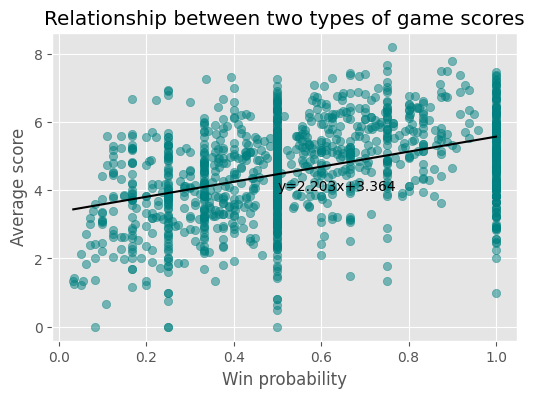

In [ ]:
plt.figure(figsize = (6,4))
plt.style.use('ggplot')
plt.scatter(x = winner, y =score, alpha = 0.5, color = 'teal')
coeff = np.polyfit(winner, score, 1)  # 1=linear

m = coeff[0]
b = coeff[1]

Vtrend = np.linspace(np.min(winner), np.max(winner), 100)
Ttrend = m * Vtrend + b
plt.plot(Vtrend, Ttrend, "black")
plt.xlabel('Win probability')
plt.ylabel('Average score')
plt.title('Relationship between two types of game scores')
plt.text(x = 0.5, y = 4, s = 'y={}x+{}'.format(round(m,3),round(b,3)))
plt.show()

### Heterogenous graph data preparation

In [ ]:
### (game1, player0), ..., (game1, player7) 게임마다 노드 여러개로 만들어보기

values = pd.DataFrame(list(player_avg_scores.values())).std()

player_x = [[(player_avg_scores.get(x,average_of_average_scores)-average_of_average_scores)/values[0],player_avg_counts.get(x,average_of_average_counts), scaled_page_rank.get(x, page_rank_mean)] for x in player_idx]

edge_source = []
edge_destination = []
game_edge_source = []
game_edge_destination = []
player_edge_source = []
player_edge_destination = []
game_y = []
game_x = []

train_pnum = []
val_pnum = []
test_pnum = []

# train set에서
# Iterate through the rows of the DataFrame
game_idx = 0
for index, row in tqdm(s_train_df.iterrows(),total=s_train_df.shape[0]):
    sources = []
    p_number = int((len(row.dropna())-2)/2)
    for i in range(p_number):
      player = row[f'player {i}']
      p_index = player_idx.index(player)
      score = int(row[f'score {i}'])
      sources.append(p_index)
      game_y.append([score])
      game_x.append([p_number])
    for p in range(len(sources)):
      edge_source.append(sources[p])
      edge_destination.append(game_idx+p)
    combi = combinations(list(range(game_idx,game_idx+p_number)),2)
    for c in combi:
      game_edge_source.append(c[0])
      game_edge_destination.append(c[1])
    game_idx += p_number
    train_pnum.append(p_number)
    p_combi = combinations(sources, 2)
    for c2 in p_combi:
      player_edge_source.append(c2[0])
      player_edge_destination.append(c2[1])

train_num = len(game_y)
print(len(train_pnum))

# validation set에서
for index, row in tqdm(s_val_df.iterrows(), total=s_val_df.shape[0]):
    sources = []
    p_number = int((len(row.dropna())-3)/2)
    for i in range(p_number):
      player = row[f'player {i}']
      p_index = player_idx.index(player)
      score = int(row[f'score {i}'])
      sources.append(p_index)
      game_y.append([score])
      game_x.append([p_number])
    for p in range(len(sources)):
      edge_source.append(sources[p])
      edge_destination.append(game_idx+p)
    combi = combinations(list(range(game_idx,game_idx+p_number)),2)
    for c in combi:
      game_edge_source.append(c[0])
      game_edge_destination.append(c[1])
    game_idx += p_number
    val_pnum.append(p_number)
    p_combi = combinations(sources, 2)
    for c2 in p_combi:
      player_edge_source.append(c2[0])
      player_edge_destination.append(c2[1])

val_num = len(game_y) - train_num
print(len(val_pnum))

# test set에서
for index, row in tqdm(test_df.iterrows(),total=test_df.shape[0]):
    sources = []
    p_number = int((len(row.dropna())-2))
    for i in range(p_number):
      player = row[f'player {i}']
      p_index = player_idx.index(player)
      sources.append(p_index)
      game_y.append([0])
      game_x.append([p_number])
    for p in range(len(sources)):
      edge_source.append(sources[p])
      edge_destination.append(game_idx+p)
    combi = combinations(list(range(game_idx,game_idx+p_number)),2)
    for c in combi:
      game_edge_source.append(c[0])
      game_edge_destination.append(c[1])
    game_idx += p_number
    test_pnum.append(p_number)
    p_combi = combinations(sources, 2)
    for c2 in p_combi:
      player_edge_source.append(c2[0])
      player_edge_destination.append(c2[1])

test_num = len(game_y) - train_num - val_num
print(len(test_pnum))
#game_x = [[0] for x in range(game_idx)]

100%|██████████| 48008/48008 [01:05<00:00, 736.02it/s] 


48008


100%|██████████| 6001/6001 [00:04<00:00, 1337.99it/s]


6001


100%|██████████| 5646/5646 [00:06<00:00, 869.04it/s]

5646


In [ ]:
len(edge_source)

286074

In [ ]:
# data 정의
data = HeteroData()
data['game'].x = torch.tensor(game_x).type(torch.float) # feature: number of player
data['player'].x = torch.tensor(player_x).type(torch.float) # feature: player_average_score, average win prob in onetoone, pagerank

data['game'].y = torch.tensor(game_y).type(torch.float)

data['player','participates','game'].edge_index = torch.tensor([edge_source,edge_destination])

data['game','same with','game'].edge_index = torch.tensor([game_edge_source,game_edge_destination])
data['player','same game','player'].edge_index = torch.tensor([player_edge_source, player_edge_destination])
data = T.ToUndirected()(data)

data['game'].train_mask = torch.zeros(data['game'].num_nodes, dtype=torch.bool)
data['game'].train_mask[:train_num] = 1 # game node 2개로 할 때는 곱하기 2 해줌 / train set일 경우 1로 해줌
data['game'].val_mask = torch.zeros(data['game'].num_nodes, dtype=torch.bool)
data['game'].val_mask[train_num:train_num+val_num] = 1
data['game'].test_mask = torch.zeros(data['game'].num_nodes, dtype=torch.bool)
data['game'].test_mask[train_num+val_num:] = 1

data = data.cuda()
print(data)

HeteroData(
  game={
    x=[286074, 1],
    y=[286074, 1],
    train_mask=[286074],
    val_mask=[286074],
    test_mask=[286074],
  },
  player={ x=[5943, 3] },
  (player, participates, game)={ edge_index=[2, 286074] },
  (game, same with, game)={ edge_index=[2, 1313830] },
  (player, same game, player)={ edge_index=[2, 889376] },
  (game, rev_participates, player)={ edge_index=[2, 286074] }
)


### Constructing heterogenous graph model

In [ ]:
class GNN3(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), 128)
        self.conv2 = SAGEConv((-1, -1), 256)
        self.conv3 = SAGEConv((-1, -1), 512)
        self.linear = torch.nn.Linear(512, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        x = self.linear(x)
        return x

class GNN5(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), 32)
        self.conv2 = SAGEConv((-1, -1), 64)
        self.conv3 = SAGEConv((-1, -1), 128)
        self.conv4 = SAGEConv((-1, -1), 256)
        self.conv5 = SAGEConv((-1, -1), 512)
        self.linear = torch.nn.Linear(512, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index)
        x = self.linear(x)
        return x

class GNN(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), 32)
        self.conv2 = SAGEConv((-1, -1), 64)
        self.conv3 = SAGEConv((-1, -1), 128)
        self.conv4 = SAGEConv((-1, -1), 128)
        self.conv5 = SAGEConv((-1, -1), 256)
        self.conv6 = SAGEConv((-1, -1), 256)
        self.conv7 = SAGEConv((-1, -1), 512)
        self.linear = torch.nn.Linear(512, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index).relu()
        x = self.conv6(x, edge_index).relu()
        x = self.conv7(x, edge_index)
        x = self.linear(x)
        return x

class GNN9(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), 32)
        self.conv2 = SAGEConv((-1, -1), 32)
        self.conv3 = SAGEConv((-1, -1), 64)
        self.conv4 = SAGEConv((-1, -1), 64)
        self.conv5 = SAGEConv((-1, -1), 128)
        self.conv6 = SAGEConv((-1, -1), 128)
        self.conv7 = SAGEConv((-1, -1), 256)
        self.conv8 = SAGEConv((-1, -1), 256)
        self.conv9 = SAGEConv((-1, -1), 512)
        self.linear = torch.nn.Linear(512, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index).relu()
        x = self.conv6(x, edge_index).relu()
        x = self.conv7(x, edge_index).relu()
        x = self.conv8(x, edge_index).relu()
        x = self.conv9(x, edge_index)
        x = self.linear(x)
        return x


model = GNN(out_channels=1)
model = to_hetero(model, data.metadata(), aggr='sum')
model = model.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004)

/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'same with' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'same game' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(


In [ ]:
import time
import copy

losses = []
training_accuracies = []
validation_accuracies = []

def test(m):
    model.eval()
    if m == 'train':
        mask = data['game'].train_mask
        p_num = train_pnum
    elif m == 'val':
        mask = data['game'].val_mask
        p_num = val_pnum

    pred = model(data.x_dict, data.edge_index_dict)['game'][mask].tolist()
    pred =[[0] if int(round(x[0])) < 0 else [9] if int(round(x[0])) > 9 else [int(round(x[0]))] for x in pred]

    answer= data['game'].y[mask].tolist()
    answer = [[int(element[0])] for element in answer]

    avg_score_err = 0
    ind_score_err = 0
    p_i = 0
    for pn in p_num:
        answer_i = answer[p_i:p_i+pn]
        pred_i = pred[p_i:p_i+pn]
        ans_sum = sum(element[0] for element in answer_i)
        pred_sum = sum(element[0] for element in pred_i)
        avg_score_err = avg_score_err + abs(ans_sum - pred_sum)/(pn*9)
        ind_score_err = ind_score_err + sum([abs(a[0] - b[0]) for a, b in zip(answer_i, pred_i)])/(pn*9)
        p_i += pn
    acc = (len(p_num) - avg_score_err/2 - ind_score_err/2)*100/len(p_num)
    #acc = (pred == data['game'].y.argmax(dim=-1)).sum() / data['game'].y.size()[0]
    return float(acc)

def train_model(model, num_epochs=300):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()
    max_val_acc = 0
    max_val_epoch = 0
    early_stopping = 0

    for epoch in range(num_epochs):
        if early_stopping >= 50 :
          print('Early stopped')
          break
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        model.train()            # Set model to training mode

        optimizer.zero_grad()

        out = model(data.x_dict, data.edge_index_dict)
        mask = data['game'].train_mask
        loss_func = nn.MSELoss()
        loss = loss_func(out['game'][mask], data['game'].y[mask])

        loss.backward()
        optimizer.step()

        train_acc = test('train')
        val_acc = test('val')
        if val_acc > max_val_acc:
          max_val_acc = val_acc
          max_val_epoch = epoch
          torch.save(model, 'best_model.pt')
          early_stopping = 0
        else :
          early_stopping += 1

        losses.append(loss)
        training_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)

        print('Loss: {:.4f}'.format(float(loss)))
        print('Train Accuracy: {:.4f}'.format(float(train_acc)))
        print('Validation Accuracy: {:.4f}'.format(float(val_acc)))



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('best_val_acc: '+str(max_val_acc)+' at epoch: '+str(max_val_epoch))

### Model training

In [ ]:
train_model(model)

**Layer 개수 비교**  
layer 3 : 86.46  
layer 5 : 86.43   
layer 7 : 86.79  
layer 9 : 86.75    

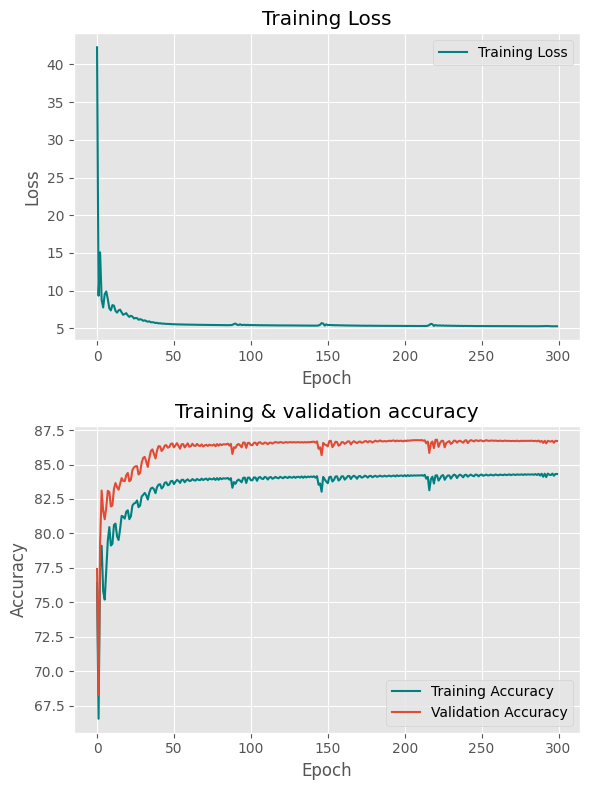

In [ ]:
losses = [x.cpu().detach() for x in losses]
plt.figure(figsize=(6,8))
plt.style.use('ggplot')

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(losses, label='Training Loss', color='teal')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(training_accuracies, label='Training Accuracy', color='teal')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & validation accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Model prediction for test data

In [ ]:
model = torch.load('best_model.pt')
model.eval()
answer = pd.DataFrame(np.nan, index = range(len(test_pnum)),columns=['game', 'score 0','score 1','score 2','score 3','score 4','score 5','score 6','score 7'])
with torch.no_grad():
  mask = data['game'].test_mask
  p_num = test_pnum
  pred = model(data.x_dict, data.edge_index_dict)['game'][mask].tolist()
  pred =[[0] if int(round(x[0])) < 0 else [9] if int(round(x[0])) > 9 else [int(round(x[0]))] for x in pred]

  p_i = 0
  for i in range(len(p_num)):
    game_id = test_df['game'][i]
    pn = p_num[i]
    pred_i = pred[p_i:p_i+pn]
    p_i += pn
    prediction = [[game_id]] + pred_i
    for j in range(len(prediction)) :
      p = prediction[j][0]
      answer.iloc[i, j] = p

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [ ]:
answer.to_csv('survival_test_prediction.csv', index = False)